In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

## Defining features and target(s)

In [3]:
features = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",

    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
    
    "CRS_DEP_TIME",
    "DEP_TIME_BLK",
    "CRS_ARR_TIME",
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
]

target = "DEP_DELAY"

## Importing the training datasets

In [4]:
# Get the current script's directory
current_script_dir = os.getcwd()

# Move up to the parent directory
parent_dir = os.path.dirname(current_script_dir)

# Define the sibling data directory name
data_dir = os.path.join(parent_dir, 'data')

# Load the 2022 training datset
# Use os.path.join to create the full file path
training_dataset_filename = "encoded_training_dataset_2022.csv"
file_path = os.path.join(data_dir, training_dataset_filename)

# Read the CSV file into a DataFrame
dataset_df = pd.read_csv(file_path)
training_df = dataset_df[features+ [target]].copy()

# Display the DataFrame
display(training_df)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_CITY_MARKET_ID,ORIGIN_STATE_FIPS,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_CITY_MARKET_ID,DEST_STATE_FIPS,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,DEP_DELAY
0,1,1,1,6,20363,360,4732,10135,30135,42,23,11433,31295,26,43,1015,5,1209,7,114,425,2,-1
1,1,1,1,6,20363,360,5430,11433,31295,26,43,10135,30135,42,23,1422,9,1548,10,86,425,2,-3
2,1,1,1,6,20363,414,4671,10397,30397,13,34,14783,34783,29,64,2057,15,2149,16,112,563,3,-5
3,1,1,1,6,20363,414,5009,13487,31650,27,63,11423,31423,19,61,1041,5,1153,6,72,232,1,-3
4,1,1,1,6,20363,414,5083,11423,31423,19,61,10397,30397,13,34,1300,8,1610,11,130,743,3,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6551768,4,12,31,6,20452,5292,5741,12953,31703,36,22,11066,31066,39,44,830,3,1038,5,128,479,2,-7
6551769,4,12,31,6,20452,6245,3607,14321,34321,23,12,13930,30977,17,41,635,1,758,2,143,900,4,-7
6551770,4,12,31,6,20452,6245,3686,13930,30977,17,41,14321,34321,23,12,1800,13,2129,16,149,900,4,-7
6551771,4,12,31,6,20452,6245,3699,11003,31003,19,61,13930,30977,17,41,1508,10,1627,11,79,196,1,-10


In [5]:
training_df.dtypes

QUARTER                  int64
MONTH                    int64
DAY_OF_MONTH             int64
DAY_OF_WEEK              int64
OP_CARRIER_AIRLINE_ID    int64
TAIL_NUM                 int64
OP_CARRIER_FL_NUM        int64
ORIGIN_AIRPORT_ID        int64
ORIGIN_CITY_MARKET_ID    int64
ORIGIN_STATE_FIPS        int64
ORIGIN_WAC               int64
DEST_AIRPORT_ID          int64
DEST_CITY_MARKET_ID      int64
DEST_STATE_FIPS          int64
DEST_WAC                 int64
CRS_DEP_TIME             int64
DEP_TIME_BLK             int64
CRS_ARR_TIME             int64
ARR_TIME_BLK             int64
CRS_ELAPSED_TIME         int64
DISTANCE                 int64
DISTANCE_GROUP           int64
DEP_DELAY                int64
dtype: object

In [6]:
categorical_columns = [
    "OP_CARRIER_AIRLINE_ID",
    "TAIL_NUM",
    "OP_CARRIER_FL_NUM",

    "ORIGIN_AIRPORT_ID",
    "ORIGIN_CITY_MARKET_ID",
    "ORIGIN_STATE_FIPS",
    "ORIGIN_WAC",
    "DEST_AIRPORT_ID",
    "DEST_CITY_MARKET_ID",
    "DEST_STATE_FIPS",
    "DEST_WAC",
]

for column in categorical_columns:
    training_df[column] = training_df[column].astype('category')

In [7]:
training_df.dtypes

QUARTER                     int64
MONTH                       int64
DAY_OF_MONTH                int64
DAY_OF_WEEK                 int64
OP_CARRIER_AIRLINE_ID    category
TAIL_NUM                 category
OP_CARRIER_FL_NUM        category
ORIGIN_AIRPORT_ID        category
ORIGIN_CITY_MARKET_ID    category
ORIGIN_STATE_FIPS        category
ORIGIN_WAC               category
DEST_AIRPORT_ID          category
DEST_CITY_MARKET_ID      category
DEST_STATE_FIPS          category
DEST_WAC                 category
CRS_DEP_TIME                int64
DEP_TIME_BLK                int64
CRS_ARR_TIME                int64
ARR_TIME_BLK                int64
CRS_ELAPSED_TIME            int64
DISTANCE                    int64
DISTANCE_GROUP              int64
DEP_DELAY                   int64
dtype: object

In [8]:
numerical_columns = [
    "QUARTER",
    "MONTH",
    "DAY_OF_MONTH",
    "DAY_OF_WEEK",
    
    "CRS_DEP_TIME",
    "DEP_TIME_BLK",
    "CRS_ARR_TIME",
    "ARR_TIME_BLK",
    "CRS_ELAPSED_TIME",
    "DISTANCE",
    "DISTANCE_GROUP",
]

In [9]:
# Normalize numerical features (scaling them)
scaler = StandardScaler()
num_features = scaler.fit_transform(training_df[numerical_columns])

# Combine the encoded categorical features with the normalized numerical features
X = np.hstack((training_df[categorical_columns].values, num_features))

# Target variable
y = training_df[target].values

# Reshape the data to fit LSTM input format (samples, time_steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # 1 time step per sample

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=123)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (3275886, 1, 22)
Testing data shape: (3275887, 1, 22)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()

# LSTM layer
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Output layer (for regression, single output neuron)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display model summary
model.summary()

C:\Users\mghun\miniconda3\envs\flight-delay\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          14,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,651 (57.23 KB)

 Trainable params: 14,651 (57.23 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 4510.2778 - val_loss: 2776.9854
Epoch 2/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 2720.9128 - val_loss: 2750.3840
Epoch 3/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 2693.9280 - val_loss: 2784.4812
Epoch 4/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 79s 2ms/step - loss: 2720.0305 - val_loss: 2779.9548
Epoch 5/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - loss: 2737.6804 - val_loss: 2746.6846
Epoch 6/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - loss: 2728.5447 - val_loss: 2750.9734
Epoch 7/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 83s 2ms/step - loss: 2726.0352 - val_loss: 2747.4019
Epoch 8/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 2744.1572 - val_loss: 2743.2244
Epoch 9/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 2670.8164 - val_loss: 2745.5283
Epoch 10/10
51186/51186 ━━━━━━━━━━━━━━━━━━━━ 77s 1ms/step - loss: 2729.1294 - val_loss: 2748.8809


In [12]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {test_loss}")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compare predictions with actual values
print(f"Predictions: {y_pred.flatten()}")
print(f"True values: {y_test}")

Test Loss (MSE): 2748.869140625
102372/102372 ━━━━━━━━━━━━━━━━━━━━ 66s 645us/step
Predictions: [25.277164  11.659007   7.1711025 ... 15.570282   7.1711025 17.056135 ]
True values: [ 14   0  -9 ...   4 -11  -4]


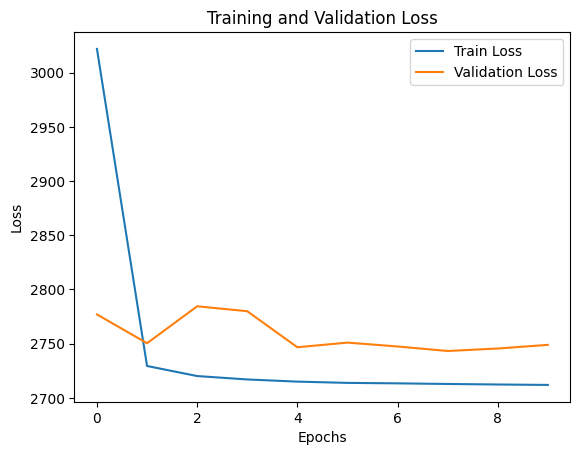

In [13]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MAE (Mean Absolute Error): {mae}")

102372/102372 ━━━━━━━━━━━━━━━━━━━━ 75s 729us/step
RMSE (Root Mean Squared Error): 52.42966584862827
MAE (Mean Absolute Error): 24.133332173880255
